# 🔧 BRK-A-01 Topology Optimization

Notebook interattivo per il caso pilota **BRK-A-01** - Staffa Aeronautica.

**Obiettivo:** Eseguire topology optimization SIMP 3D per minimizzare la compliance
con vincolo di volume al 25%.

---

## 1. Setup e Import

In [23]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Moduli progetto
from src.geometry import create_bracket_domain, VoxelDomain
from src.loads import create_brk_a_01_static_case_1, LoadCase
from src.fem import MaterialProperties
from src.topopt import SIMPOptimizer, SIMPParams, TOResult

print("Imports completati ✓")

Imports completati ✓


## 2. Creazione Dominio Voxel

Creiamo la griglia 3D con le zone:
- **Fixed (1):** Base e occhiello
- **Design (0):** Volume ottimizzabile
- **Void (-1):** Fori

In [24]:
# Parametri dominio
# NOTA: Per test rapidi, usare risoluzione più bassa (es. 5mm)
RESOLUTION_MM = 4.0  # mm (usa 1.0 per produzione)

# Crea dominio
domain = create_bracket_domain(
    size_mm=(120, 60, 80),
    resolution_mm=RESOLUTION_MM
)

print(f"📐 Dominio creato:")
print(f"   Shape: {domain.shape}")
print(f"   Size: {domain.size_mm} mm")
print(f"   Elementi totali: {domain.n_elements:,}")
print(f"   Design space: {domain.n_design:,} elementi")
print(f"   Fixed: {domain.n_fixed:,} elementi")

📐 Dominio creato:
   Shape: (30, 15, 20)
   Size: (120.0, 60.0, 80.0) mm
   Elementi totali: 9,000
   Design space: 8,445 elementi
   Fixed: 490 elementi


/var/folders/j4/lw9rt9517k134dz28rgq71r40000gn/T/ipykernel_66558/943641649.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


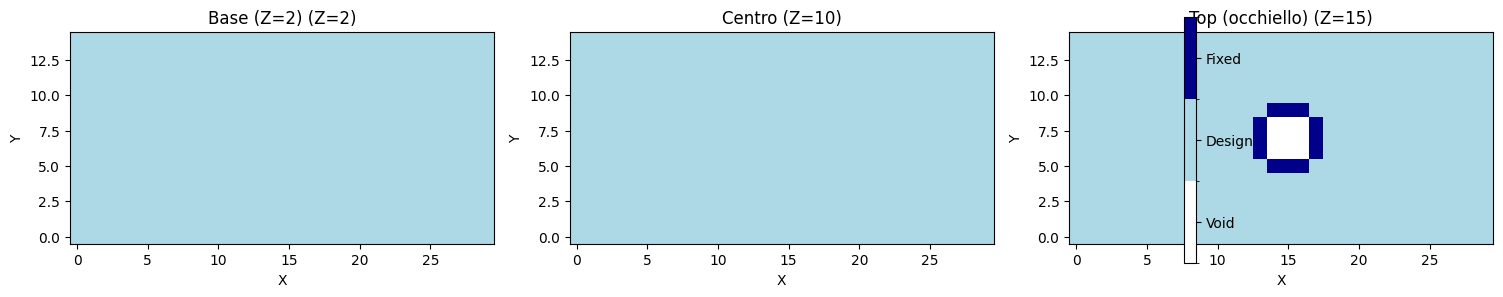

In [25]:
# Visualizza slice del dominio
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Slice a diversi livelli Z
z_levels = [2, domain.shape[2]//2, domain.shape[2]-5]
titles = ['Base (Z=2)', 'Centro', 'Top (occhiello)']

cmap = plt.cm.colors.ListedColormap(['white', 'lightblue', 'darkblue'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

for ax, z, title in zip(axes, z_levels, titles):
    im = ax.imshow(domain.grid[:, :, z].T, cmap=cmap, norm=norm, origin='lower')
    ax.set_title(f'{title} (Z={z})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# Colorbar
cbar = plt.colorbar(im, ax=axes, ticks=[-1, 0, 1], shrink=0.8)
cbar.ax.set_yticklabels(['Void', 'Design', 'Fixed'])

plt.tight_layout()
plt.show()

## 3. Definizione Carichi

**Caso Statico 1:** Carico verticale 15 kN sull'occhiello, base vincolata.

In [26]:
# Crea load case
load_case = create_brk_a_01_static_case_1(
    domain_shape=domain.shape,
    resolution_mm=RESOLUTION_MM
)

print(f"📌 Load Case: {load_case.name}")
print(f"   {load_case.description}")
print(f"   Nodi vincolati (base): {load_case.boundary_conditions[0].n_nodes}")

if load_case.distributed_loads:
    dl = load_case.distributed_loads[0]
    print(f"   Carico distribuito su {len(dl.node_indices)} nodi")
    print(f"   Forza totale: {dl.total_force} N")

📌 Load Case: BRK-A-01_Static_1
   Carico verticale 15kN sull'occhiello, base vincolata
   Nodi vincolati (base): 496
   Carico distribuito su 12 nodi
   Forza totale: [     0.      0. -15000.] N


## 4. Proprietà Materiale

**Ti6Al4V** - Lega di titanio per applicazioni aerospaziali.

In [27]:
material = MaterialProperties(
    E=113.8e9,    # 113.8 GPa
    nu=0.342,
    rho=4430.0    # kg/m³
)

print(f"🔩 Materiale: Ti6Al4V")
print(f"   E = {material.E/1e9:.1f} GPa")
print(f"   ν = {material.nu}")
print(f"   ρ = {material.rho} kg/m³")

🔩 Materiale: Ti6Al4V
   E = 113.8 GPa
   ν = 0.342
   ρ = 4430.0 kg/m³


## 5. Parametri Ottimizzazione SIMP

In [28]:
params = SIMPParams(
    volume_fraction=0.25,    # 25% volume target
    penalty=3.0,             # Penalità SIMP
    filter_radius=2.0,       # Raggio filtro [elementi]
    move_limit=0.2,          # Max variazione per iter
    max_iterations=50,       # Ridotto per test
    convergence_tol=0.01
)

print(f"⚙️ Parametri SIMP:")
print(f"   Volume target: {params.volume_fraction:.0%}")
print(f"   Penalità: {params.penalty}")
print(f"   Filtro: {params.filter_radius} elementi")
print(f"   Max iterazioni: {params.max_iterations}")

⚙️ Parametri SIMP:
   Volume target: 25%
   Penalità: 3.0
   Filtro: 2.0 elementi
   Max iterazioni: 50


## 6. Esecuzione Topology Optimization

⚠️ **Attenzione:** Con griglia fine (1mm) il calcolo può richiedere diversi minuti.

In [29]:
# Crea ottimizzatore
optimizer = SIMPOptimizer(
    domain=domain,
    load_cases=[load_case],
    material=material,
    params=params,
    verbose=True
)

# Esegui ottimizzazione
print("\n🚀 Avvio ottimizzazione...\n")
result = optimizer.run()


🚀 Avvio ottimizzazione...

SIMP Topology Optimization
Grid size: 30 x 15 x 20
Design elements: 8,445
Target volume fraction: 25.00%
Filter radius: 2.0
Penalty: 3.0
------------------------------------------------------------


/Users/ettoremiglioranza/Projects/AM/notebooks/../src/fem.py:281: MatrixRankWarning: Matrix is exactly singular
  u_f = spsolve(K_ff, F_f)


Iter   1 | Compliance: nan | Volume: nan | Change: nan
Iter   2 | Compliance: nan | Volume: nan | Change: nan
Iter   3 | Compliance: nan | Volume: nan | Change: nan
Iter   4 | Compliance: nan | Volume: nan | Change: nan
Iter   5 | Compliance: nan | Volume: nan | Change: nan


KeyboardInterrupt: 

## 7. Analisi Risultati

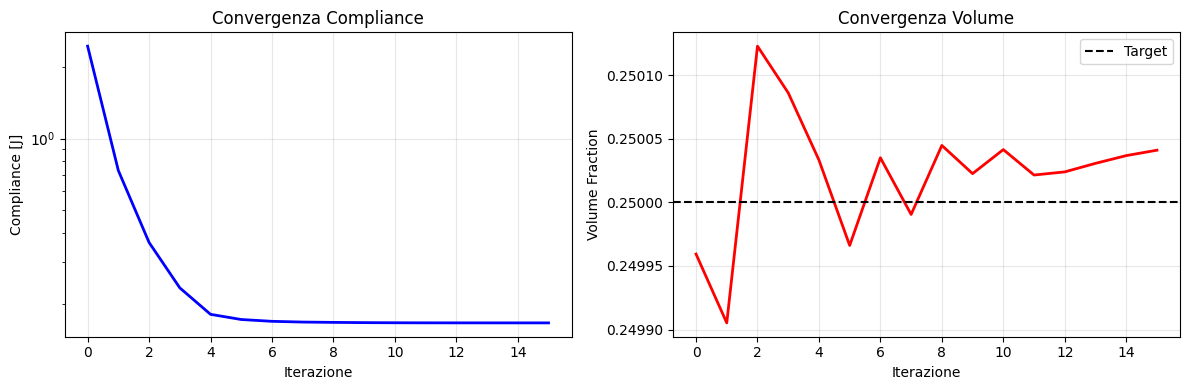


📊 Risultati finali:
   Iterazioni: 16
   Converso: True
   Compliance finale: 1.6614e-01
   Volume finale: 0.2500
   Tempo: 30.5s


In [ ]:
# Plot convergenza
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Compliance
ax1.plot(result.compliance_history, 'b-', linewidth=2)
ax1.set_xlabel('Iterazione')
ax1.set_ylabel('Compliance [J]')
ax1.set_title('Convergenza Compliance')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Volume
ax2.plot(result.volume_history, 'r-', linewidth=2)
ax2.axhline(y=params.volume_fraction, color='k', linestyle='--', label='Target')
ax2.set_xlabel('Iterazione')
ax2.set_ylabel('Volume Fraction')
ax2.set_title('Convergenza Volume')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Risultati finali:")
print(f"   Iterazioni: {result.iterations}")
print(f"   Converso: {result.converged}")
print(f"   Compliance finale: {result.final_compliance:.4e}")
print(f"   Volume finale: {result.final_volume:.4f}")
print(f"   Tempo: {result.elapsed_time:.1f}s")

/var/folders/j4/lw9rt9517k134dz28rgq71r40000gn/T/ipykernel_66558/4294055959.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


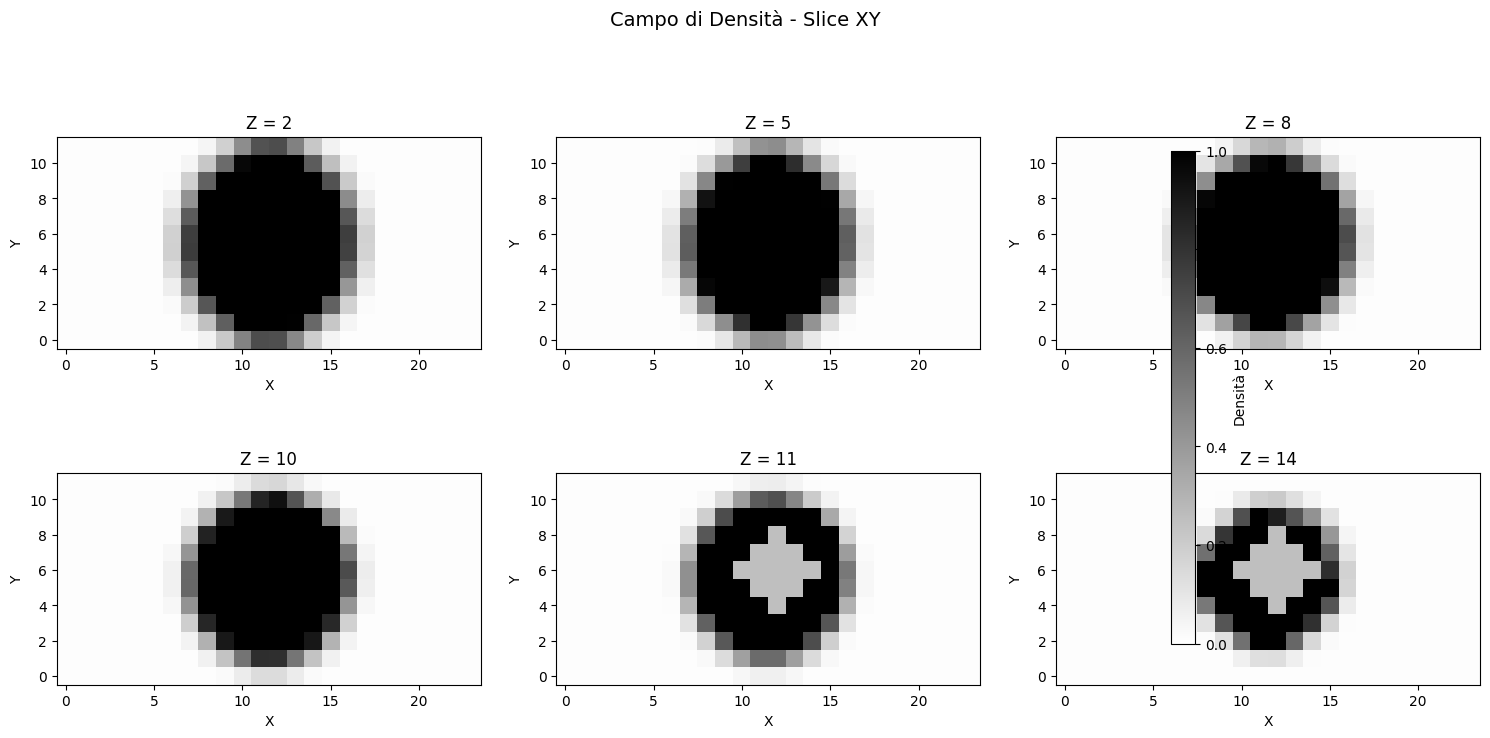

In [ ]:
# Visualizza campo di densità - Slice
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Slice XY a diversi Z
z_levels = [2, domain.shape[2]//3, domain.shape[2]//2, 
            2*domain.shape[2]//3, domain.shape[2]-5, domain.shape[2]-2]

for ax, z in zip(axes.flat, z_levels):
    im = ax.imshow(result.density[:, :, z].T, cmap='gray_r', 
                   vmin=0, vmax=1, origin='lower')
    ax.set_title(f'Z = {z}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.colorbar(im, ax=axes, label='Densità', shrink=0.8)
plt.suptitle('Campo di Densità - Slice XY', fontsize=14)
plt.tight_layout()
plt.show()

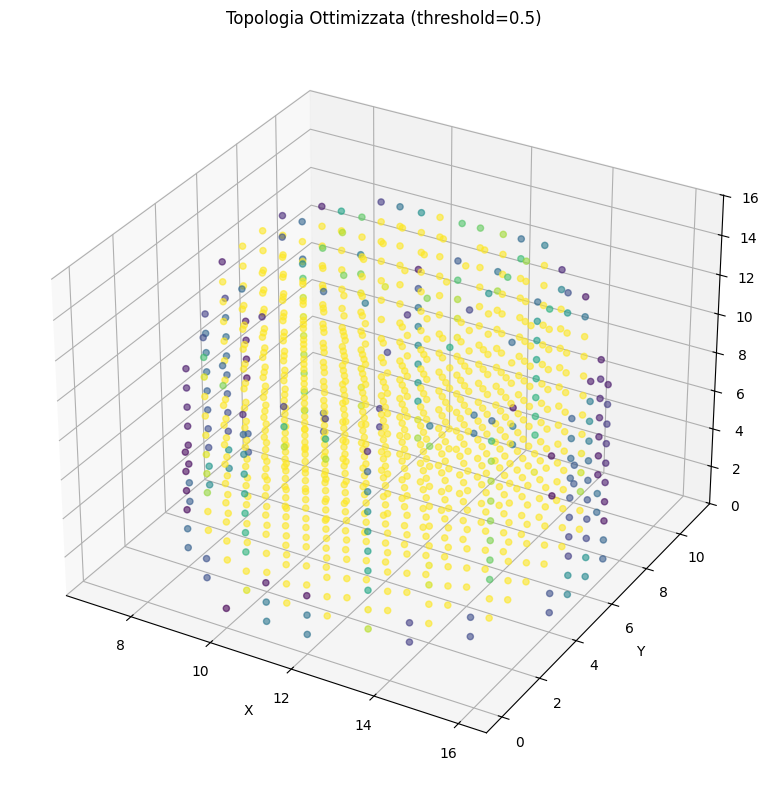


🎯 Voxel solidi (ρ ≥ 0.5): 991
   Percentuale: 23.2% del design space


In [ ]:
# Visualizzazione 3D semplificata
# (per visualizzazione avanzata usare PyVista)

threshold = 0.5
solid = result.density >= threshold

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Trova voxel solidi
x, y, z = np.where(solid)

# Subsample per performance
if len(x) > 5000:
    idx = np.random.choice(len(x), 5000, replace=False)
    x, y, z = x[idx], y[idx], z[idx]

ax.scatter(x, y, z, c=result.density[x, y, z], cmap='viridis', 
           s=20, alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Topologia Ottimizzata (threshold={threshold})')

plt.tight_layout()
plt.show()

print(f"\n🎯 Voxel solidi (ρ ≥ {threshold}): {np.sum(solid):,}")
print(f"   Percentuale: {np.sum(solid)/domain.n_design*100:.1f}% del design space")

## 8. Export Risultati

In [ ]:
# Salva campo di densità
output_path = '../data/brk_a_01/density_field.npy'
np.save(output_path, result.density)
print(f"💾 Campo densità salvato in: {output_path}")

# Salva metadati
metadata = {
    'case': 'BRK-A-01',
    'resolution_mm': RESOLUTION_MM,
    'shape': domain.shape,
    'volume_fraction_target': params.volume_fraction,
    'volume_fraction_final': result.final_volume,
    'compliance_final': result.final_compliance,
    'iterations': result.iterations,
    'converged': result.converged
}

import json
with open('../data/brk_a_01/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print("💾 Metadati salvati")

💾 Campo densità salvato in: ../data/brk_a_01/density_field.npy
💾 Metadati salvati


---

## 📝 Prossimi Passi

1. **Aumentare risoluzione** a 1mm per risultato finale
2. **Aggiungere vincoli DfAM:** overhang, minimum member size
3. **Multi-load case:** includere Caso Statico 2
4. **Export STL:** mesh del risultato per stampa
5. **Validazione FEM:** verifica stress con mesh fine